In [21]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

import json 
import pandas as pd 
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [2]:
#Load training data
with open('../data/random-acts-of-pizza/train.json') as f:
    train_json = json.load(f)
    
# Load test data
with open('../data/random-acts-of-pizza/test.json') as f:
    test_json = json.load(f)


### Clean Input

In [3]:
train = json_normalize(train_json)
test = json_normalize(test_json)

train["request_title"] = train["request_title"].str.lower()
test["request_title"] = test["request_title"].str.lower()

train["request_title"] = train["request_title"].str.replace('\[request\]','')
test["request_title"] = test["request_title"].str.replace('\[request\]','')
train["request_title"] = train["request_title"].str.replace('request','')
test["request_title"] = test["request_title"].str.replace('request','')
train['request_text'] = train['request_text'].str.lower()

### Divide data into training and dev sets

In [4]:
train_data = train[:2800]
train_labels = train[:2800]['requester_received_pizza']
test_data = test[:]

dev_data = train[2800:]
dev_labels = train[2800:]['requester_received_pizza']

train_data_title = train_data['request_title']
dev_data_title = dev_data['request_title']
test_data_title = test_data['request_title']

### Inspect Data

In [5]:
print('training data shape:', train_data.shape)
print('training label shape:', train_labels.shape)
print('dev data shape:',     dev_data.shape)
print('dev label shape:',      dev_labels.shape)

print('training data shape title:',      train_data_title.shape)
print('dev data shape title:',      dev_data_title.shape)
train.head()

training data shape: (2800, 32)
training label shape: (2800,)
dev data shape: (1240, 32)
dev label shape: (1240,)
training data shape title: (2800,)
dev data shape title: (1240,)


,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_received_pizza,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc
0,N/A,0,1,False,t3_l25d7,0,hi i am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,colorado springs help us please,0.000000,...,False,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09
1,N/A,2,5,False,t3_rcb83,0,i spent the last money i had on gas today. im ...,I spent the last money I had on gas today. Im ...,"california, no cash and i could use some dinner",501.111100,...,False,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09
2,N/A,0,3,False,t3_lpu5j,0,my girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"hungry couple in dundee, scotland would love ...",0.000000,...,False,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09
3,N/A,0,1,True,t3_mxvj3,4,"it's cold, i'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","in canada (ontario), just got home from schoo...",6.518438,...,False,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n i love this sub. i think it's grea...,hey guys:\n I love this sub. I think it's grea...,old friend coming to visit. would love to fee...,162.063252,...,False,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09


Our task is to detect which posts result in pizza and which do not. 

In [6]:
train.describe()

,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,request_number_of_comments_at_retrieval,requester_account_age_in_days_at_request,requester_account_age_in_days_at_retrieval,requester_days_since_first_post_on_raop_at_request,requester_days_since_first_post_on_raop_at_retrieval,requester_number_of_comments_at_request,requester_number_of_comments_at_retrieval,requester_number_of_comments_in_raop_at_request,...,requester_number_of_posts_at_retrieval,requester_number_of_posts_on_raop_at_request,requester_number_of_posts_on_raop_at_retrieval,requester_number_of_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,unix_timestamp_of_request,unix_timestamp_of_request_utc
count,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,...,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4040.000000,4.040000e+03,4.040000e+03,4.040000e+03,4.040000e+03
mean,2.424505,6.180446,2.871040,254.586579,757.692720,16.417034,518.993205,115.098267,289.425743,0.645050,...,41.151733,0.063614,1.239109,18.076733,1160.079950,2720.342079,3.743236e+03,7.788069e+03,1.342829e+09,1.342826e+09
std,3.023101,10.746320,4.723339,303.275730,333.035728,70.651428,267.872623,193.318968,357.416133,3.413813,...,80.798543,0.325773,0.603083,21.736465,3718.365515,6264.378878,2.583816e+04,3.916741e+04,2.333057e+07,2.332989e+07
min,0.000000,0.000000,0.000000,0.000000,45.291562,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-173.000000,-173.000000,0.000000e+00,0.000000e+00,1.297723e+09,1.297723e+09
25%,1.000000,2.000000,0.000000,3.473168,522.248455,0.000000,279.009051,0.000000,8.000000,0.000000,...,2.000000,0.000000,1.000000,1.000000,3.000000,22.000000,9.000000e+00,5.200000e+01,1.320469e+09,1.320466e+09
50%,2.000000,4.000000,1.000000,157.067170,753.270874,0.000000,528.781939,24.000000,114.000000,0.000000,...,13.000000,0.000000,1.000000,11.000000,174.500000,708.000000,3.510000e+02,1.283500e+03,1.342565e+09,1.342561e+09
75%,3.000000,7.000000,4.000000,390.092653,900.349838,0.000000,776.226670,140.250000,479.000000,0.000000,...,46.000000,0.000000,1.000000,27.000000,1163.750000,3304.000000,2.303750e+03,6.829000e+03,1.364618e+09,1.364614e+09
max,47.000000,345.000000,61.000000,2809.750787,2879.276319,785.457685,1025.407593,994.000000,1000.000000,88.000000,...,999.000000,5.000000,9.000000,186.000000,155010.000000,223708.000000,1.286864e+06,2.046482e+06,1.381552e+09,1.381523e+09


### Examine Data

 1. For first 5 training examples, print the title of request

In [7]:
def display_request(num_examples=5):

    for i in range(num_examples):
        print(train_data.iloc[i]['request_title']) 
        print(train_data.iloc[i]['request_text'])
        print('Received Pizza: ', train_data.iloc[i]['requester_received_pizza']) 
        print('\n')  

        
display_request(5)

 colorado springs help us please
hi i am in need of food for my 4 children we are a military family that has really hit hard times and we have exahusted all means of help just to be able to feed my family and make it through another night is all i ask i know our blessing is coming so whatever u can find in your heart to give is greatly appreciated
Received Pizza:  False


 california, no cash and i could use some dinner
i spent the last money i had on gas today. im broke until next thursday :(
Received Pizza:  False


 hungry couple in dundee, scotland would love some pizza!
my girlfriend decided it would be a good idea to get off at perth bus station when she was coming to visit me and has since had to spend all her money on a taxi to get to me here in dundee. any chance some kind soul would get us some pizza since we don't have any cash anymore?
Received Pizza:  False


 in canada (ontario), just got home from school. need pizza.
it's cold, i'n hungry, and to be completely honest i'm

<AxesSubplot:xlabel='requester_received_pizza'>

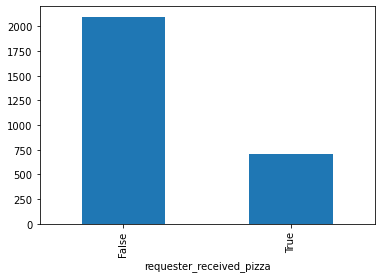

In [8]:
#Baseline accuracy
train_data.groupby('requester_received_pizza').size().plot(kind = "bar")


In [9]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

train["tokens"] = train["request_title"].apply(tokenizer.tokenize)
train.head()

,giver_username_if_known,number_of_downvotes_of_request_at_retrieval,number_of_upvotes_of_request_at_retrieval,post_was_edited,request_id,request_number_of_comments_at_retrieval,request_text,request_text_edit_aware,request_title,requester_account_age_in_days_at_request,...,requester_subreddits_at_request,requester_upvotes_minus_downvotes_at_request,requester_upvotes_minus_downvotes_at_retrieval,requester_upvotes_plus_downvotes_at_request,requester_upvotes_plus_downvotes_at_retrieval,requester_user_flair,requester_username,unix_timestamp_of_request,unix_timestamp_of_request_utc,tokens
0,N/A,0,1,False,t3_l25d7,0,hi i am in need of food for my 4 children we a...,Hi I am in need of food for my 4 children we a...,colorado springs help us please,0.000000,...,[],0,1,0,1,None,nickylvst,1.317853e+09,1.317849e+09,"[colorado, springs, help, us, please]"
1,N/A,2,5,False,t3_rcb83,0,i spent the last money i had on gas today. im ...,I spent the last money I had on gas today. Im ...,"california, no cash and i could use some dinner",501.111100,...,"[AskReddit, Eve, IAmA, MontereyBay, RandomKind...",34,4258,116,11168,None,fohacidal,1.332652e+09,1.332649e+09,"[california, no, cash, and, i, could, use, som..."
2,N/A,0,3,False,t3_lpu5j,0,my girlfriend decided it would be a good idea ...,My girlfriend decided it would be a good idea ...,"hungry couple in dundee, scotland would love ...",0.000000,...,[],0,3,0,3,None,jacquibatman7,1.319650e+09,1.319646e+09,"[hungry, couple, in, dundee, scotland, would, ..."
3,N/A,0,1,True,t3_mxvj3,4,"it's cold, i'n hungry, and to be completely ho...","It's cold, I'n hungry, and to be completely ho...","in canada (ontario), just got home from schoo...",6.518438,...,"[AskReddit, DJs, IAmA, Random_Acts_Of_Pizza]",54,59,76,81,None,4on_the_floor,1.322855e+09,1.322855e+09,"[in, canada, ontario, just, got, home, from, s..."
4,N/A,6,6,False,t3_1i6486,5,hey guys:\n i love this sub. i think it's grea...,hey guys:\n I love this sub. I think it's grea...,old friend coming to visit. would love to fee...,162.063252,...,"[GayBrosWeightLoss, RandomActsOfCookies, Rando...",1121,1225,1733,1887,None,Futuredogwalker,1.373658e+09,1.373654e+09,"[old, friend, coming, to, visit, would, love, ..."


In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

all_words = [word for tokens in train["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in train["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

47305 words total, with a vocabulary size of 4504
Max sentence length is 51


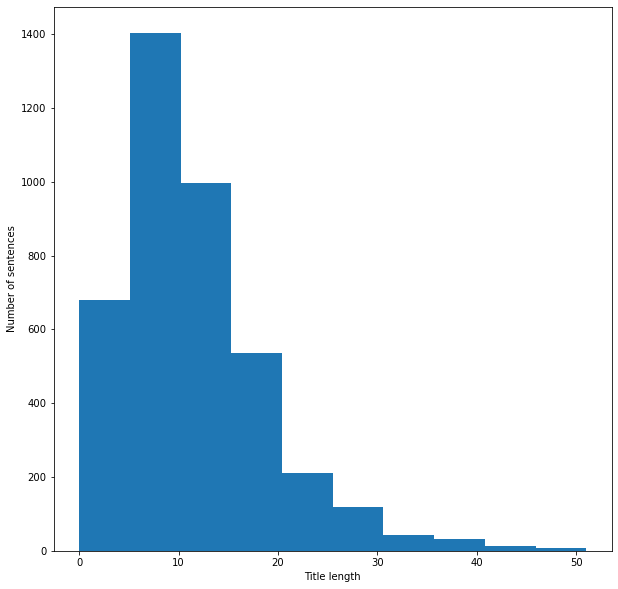

In [11]:


fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Title length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

### Classification

In [12]:
vectorizer = CountVectorizer()
vector = vectorizer.fit_transform(train_data_title)
vocab_train = vectorizer.vocabulary_

print('Size of vocabulary: ', vector.shape[1])
print("0th feature: ", vectorizer.get_feature_names_out()[0])
print("Last feature: ", vectorizer.get_feature_names_out()[-1])
print("Average number of non-zero features per example: ", round(np.average([row.nnz for row in vector]),3))
sparsity = round((vector.nnz / (vector.shape[0] * vector.shape[1])),3)
print(f'Fraction of the non-zero entries in the matrix - Sparsity: {sparsity}')

vectorizer_dev = CountVectorizer()
devvector = vectorizer_dev.fit_transform(dev_data)
vocab_dev = vectorizer_dev.vocabulary_
dev_missing_words = set(vocab_train.keys()) - set(vocab_dev.keys())
print('Dev vocab missing from the training vocab size: ', len(dev_missing_words))
print('Fraction of words in dev vocab missing from the training vocab: ', round(len(dev_missing_words)/len(vocab_train),3))
        


Size of vocabulary:  3666
0th feature:  000
Last feature:  ಠ_ಠ
Average number of non-zero features per example:  10.27
Fraction of the non-zero entries in the matrix - Sparsity: 0.003
Dev vocab missing from the training vocab size:  3666
Fraction of words in dev vocab missing from the training vocab:  1.0


In [13]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

def get_metrics(y_test, y_predicted):  
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')
    
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')
    
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1

def text_preprocessor(text):
    text = text.lower()
    text = re.sub("\W",' ',text) # replace non-alphanumeric
    text = re.sub("_",' ',text) # replace non-alphanumeric
    text = re.sub('\n', '', text)   
    return text

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', preprocessor=text_preprocessor)
train_vector = vectorizer.fit_transform(train_data_title)

dev_vector = vectorizer.transform(dev_data_title)

#Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score
print('\n***  Naive Bayes model ***') 


mnb = MultinomialNB(alpha = 0.5)
mnb.fit(train_vector, train_labels)

#Evaluate performance on the dev set.
pred_mnb = mnb.predict(dev_vector)
score = metrics.f1_score(dev_labels, pred_mnb, average="weighted")
print(f"a = 0.5, f1 score = {score}")

accuracy, precision, recall, f1 = get_metrics(dev_labels, pred_mnb)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))


***  Naive Bayes model ***
a = 0.5, f1 score = 0.6818599290644948
accuracy = 0.728, precision = 0.664, recall = 0.728, f1 = 0.682


Text(0.5, 257.44, 'Predicted label')

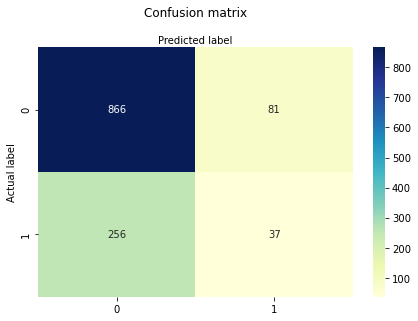

In [22]:
# Look at confusion matrix
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_mnb)
cnf_matrix

# Plot results
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [23]:


def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    
    # loop for each class
    classes ={}
    for class_index in range(model.coef_.shape[0]):
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
        bottom = sorted_coeff[-n:]
        classes[class_index] = {
            'tops':tops,
            'bottom':bottom
        }
    return classes

vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english', preprocessor=text_preprocessor)
train_vector = vectorizer.fit_transform(train_data_title)

lr = LogisticRegression(C=.5, solver="liblinear", multi_class="auto")
lr.fit(train_vector, train_labels)
pred_lr = lr.predict(dev_vector)
score = metrics.f1_score(dev_labels, pred_lr, average="weighted")
print('\n***  Logistic Regression model ***') 
print(f"a = 0.5, f1 score = {score}")

accuracy, precision, recall, f1 = get_metrics(dev_labels, pred_lr)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))        

importance = get_most_important_features(vectorizer, lr, 10)


***  Logistic Regression model ***
a = 0.5, f1 score = 0.6647950857628278
accuracy = 0.765, precision = 0.742, recall = 0.765, f1 = 0.665


Text(0.5, 257.44, 'Predicted label')

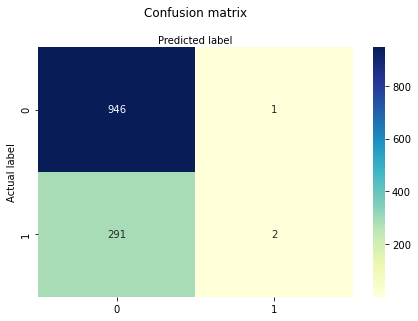

In [24]:
# Look at confusion matrix
cnf_matrix = metrics.confusion_matrix(dev_labels, pred_lr)
cnf_matrix

# Plot results
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [15]:
importance[0]['bottom']

[(-0.4519374520075376, 'pizza great'),
 (-0.4558045488907372, 'california usa'),
 (-0.4644202787861967, 'looking good'),
 (-0.46585328666592796, 'just got'),
 (-0.5303007117911611, 'need pizza'),
 (-0.5393078733974727, 'san diego'),
 (-0.5618859119676731, 'pizza right'),
 (-0.5656338159412744, 'florida usa'),
 (-0.5914088259507275, 'just moved'),
 (-0.8945730993936892, 'love pizza')]

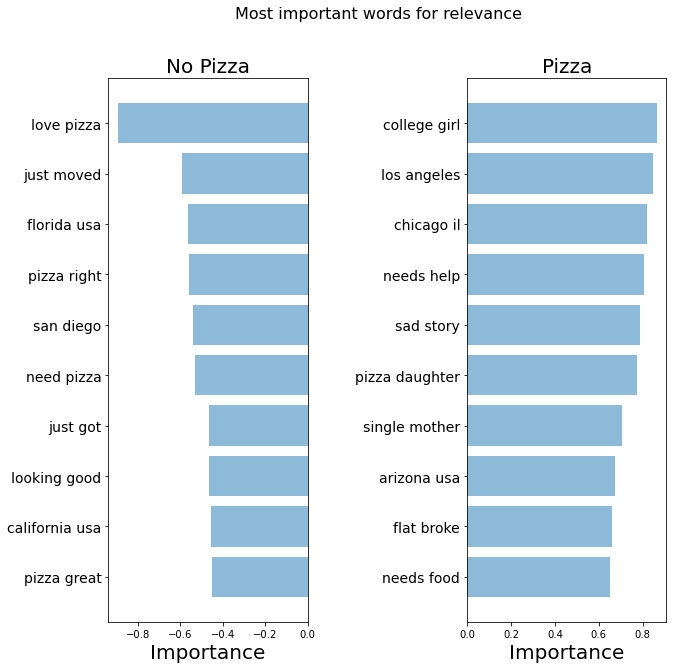

In [16]:

def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])
    
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)
    
    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]
    
    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]
    
    fig = plt.figure(figsize=(10, 10))  

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('No Pizza', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('Pizza', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)
    
    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]

plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

In [17]:
 #Tfidf Vectorizer
tfidfvectorizer = TfidfVectorizer()
train_vector_tfIdf = tfidfvectorizer.fit_transform(train_data_title)

 #transform dev tfidfvectorizer
dev_vector_tfIdf = tfidfvectorizer.transform(dev_data_title) 

#default is penalty="l2"
lr_tfIdf =  LogisticRegression(C=100, solver="liblinear", multi_class="auto")
lr_tfIdf.fit(train_vector_tfIdf, train_labels)   

pred_tfIdf = lr_tfIdf.predict(dev_vector_tfIdf)

score = metrics.f1_score(dev_labels, pred_tfIdf, average="weighted")
print(f"\n******** Tfidf Vectorizer ********")
print(f"\nTfidf C = 100, f1 score = {score}, vocab size =", len(tfidfvectorizer.vocabulary_)) 



******** Tfidf Vectorizer ********

Tfidf C = 100, f1 score = 0.6427084881751347, vocab size = 3666


In [18]:
# Understand nature of the data .info() .describe()
# Histograms and boxplots 
# Value counts 
# Missing data 
# Correlation between the metrics 
# Explore interesting themes 
    # Wealthy survive? 
    # By location 
    # Age scatterplot with ticket price 
    # Young and wealthy Variable? 
    # Total spent? 
# Feature engineering 
# preprocess data together or use a transformer? 
    # use label for train and test   
# Scaling?

# Model Baseline 
# Model comparison with CV 

In [19]:
print(no_pizza["requester_account_age_in_days_at_request"].mean())
print(pizza["requester_account_age_in_days_at_request"].mean())
print('\nrequest_number_of_comments_at_retrieval')
print(no_pizza["request_number_of_comments_at_retrieval"].mean())
print(pizza["request_number_of_comments_at_retrieval"].mean())
print('\nnumber_of_upvotes_of_request_at_retrieval')
print(no_pizza["number_of_upvotes_of_request_at_retrieval"].mean())
print(pizza["number_of_upvotes_of_request_at_retrieval"].mean())
print('\nrequester_number_of_comments_in_raop_at_request')
print(no_pizza["requester_number_of_comments_in_raop_at_request"].mean())
print(pizza["requester_number_of_comments_in_raop_at_request"].mean())
print('\nrequester_number_of_posts_at_retrieval')
print(no_pizza["requester_number_of_posts_at_retrieval"].mean())
print(pizza["requester_number_of_posts_at_retrieval"].mean())
print('\nrequester_number_of_subreddits_at_request')
print(no_pizza["requester_number_of_subreddits_at_request"].mean())
print(pizza["requester_number_of_subreddits_at_request"].mean())

no_pizza["requester_user_flair"]

NameError: name 'no_pizza' is not defined

In [ ]:
print(len(pizza["request_title"])